# Step 1.1: Data Loading & Initial Cleaning

**Objective:** Load the LinkedIn influencers dataset and perform initial cleaning operations.

## Tasks
1. Load data from EDA folder
2. Remove duplicate rows
3. Handle missing critical data (content, reactions, comments)
4. Validate and convert data types
5. Handle outliers (cap at 99th percentile)
6. Perform data quality checks
7. Save cleaned dataset

**Output:** `../data/cleaned_data.csv`

---
## Setup and Configuration

In [3]:
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path

# Configuration
INPUT_FILE = '../../eda/influencers_data.csv'
OUTPUT_DIR = '../data'
OUTPUT_FILE = 'cleaned_data.csv'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("✓ Libraries loaded and directories created")

✓ Libraries loaded and directories created


---
## 1. Load Data

In [4]:
print("="*80)
print("LOADING DATA")
print("="*80)

df = pd.read_csv(INPUT_FILE)
initial_rows = len(df)
initial_cols = len(df.columns)

print(f"✓ Loaded: {initial_rows:,} rows × {initial_cols} columns")
print(f"  - Unique influencers: {df['name'].nunique()}")
print(f"  - Columns: {list(df.columns)}")

LOADING DATA
✓ Loaded: 34,012 rows × 19 columns
  - Unique influencers: 69
  - Columns: ['slno', 'name', 'headline', 'location', 'followers', 'connections', 'about', 'time_spent', 'content', 'content_links', 'media_type', 'media_url', 'num_hashtags', 'hashtag_followers', 'hashtags', 'reactions', 'comments', 'views', 'votes']


C:\Users\rakib\AppData\Local\Temp\ipykernel_14280\3123926802.py:5: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_FILE)


In [5]:
# Display first few rows
df.head(3)

,slno,name,headline,location,followers,connections,about,time_spent,content,content_links,media_type,media_url,num_hashtags,hashtag_followers,hashtags,reactions,comments,views,votes
0,0,Nicholas Wyman,CEO IWSI Group,NaN,6484.0,500+,Nicholas Wyman for the past 25 years has shone...,1 day ago,Robert Lerman writes that achieving a healthy...,[['https://www.linkedin.com/in/ACoAAACy1HkBviR...,article,['https://www.urban.org/urban-wire/its-time-mo...,4,0,"[['#workbasedlearning', 'https://www.linkedin....",12,1,NaN,NaN
1,1,Nicholas Wyman,CEO IWSI Group,NaN,6484.0,500+,Nicholas Wyman for the past 25 years has shone...,1 week ago,"National disability advocate Sara Hart Weir, ...",[['https://www.linkedin.com/in/ACoAAAHsfJgBb7_...,NaN,[],0,0,[],11,0,NaN,NaN
2,2,Nicholas Wyman,CEO IWSI Group,NaN,6484.0,500+,Nicholas Wyman for the past 25 years has shone...,2 months ago,NaN,[],NaN,[],0,0,[],15,0,NaN,NaN


In [6]:
# Check initial data types
print("\nData Types:")
print(df.dtypes)


Data Types:
slno                   int64
name                  object
headline              object
location              object
followers            float64
connections           object
about                 object
time_spent            object
content               object
content_links         object
media_type            object
media_url             object
num_hashtags           int64
hashtag_followers      int64
hashtags              object
reactions              int64
comments               int64
views                float64
votes                 object
dtype: object


---
## 2. Remove Duplicate Rows

In [7]:
print("="*80)
print("REMOVING DUPLICATES")
print("="*80)

# Check for exact duplicates
duplicates_total = df.duplicated().sum()
print(f"Found {duplicates_total} exact duplicate rows")

if duplicates_total > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates_total} duplicates")
else:
    print("✓ No duplicates found")

# Check for duplicate content
if 'content' in df.columns:
    content_duplicates = df['content'].dropna().duplicated().sum()
    print(f"\nFound {content_duplicates} posts with duplicate content")
    print("ℹ Keeping duplicate content (may be reposts by different influencers)")

print(f"\nRows after duplicate removal: {len(df):,}")

REMOVING DUPLICATES
Found 0 exact duplicate rows
✓ No duplicates found

Found 757 posts with duplicate content
ℹ Keeping duplicate content (may be reposts by different influencers)

Rows after duplicate removal: 34,012


---
## 3. Handle Missing Critical Data

In [8]:
print("="*80)
print("HANDLING MISSING DATA")
print("="*80)

# Check missing values in critical columns
critical_columns = ['content', 'reactions', 'comments']
missing_summary = {}

print("\nMissing values in critical columns:")
for col in critical_columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = (missing_count / len(df)) * 100
        missing_summary[col] = {'count': missing_count, 'pct': missing_pct}
        print(f"  {col}: {missing_count:,} ({missing_pct:.2f}%)")

HANDLING MISSING DATA

Missing values in critical columns:
  content: 2,016 (5.93%)
  reactions: 0 (0.00%)
  comments: 0 (0.00%)


In [9]:
# Drop rows with missing content
before_drop = len(df)

if 'content' in df.columns:
    df = df[df['content'].notna()].copy()
    removed = before_drop - len(df)
    print(f"\n✓ Removed {removed:,} rows with missing content")

# Drop rows with missing target variables
before_targets = len(df)
if 'reactions' in df.columns and 'comments' in df.columns:
    df = df[(df['reactions'].notna()) & (df['comments'].notna())].copy()
    removed = before_targets - len(df)
    if removed > 0:
        print(f"✓ Removed {removed:,} rows with missing reactions/comments")
    else:
        print(f"✓ All rows have reactions and comments data")

print(f"\nRows after handling missing data: {len(df):,}")


✓ Removed 2,016 rows with missing content
✓ All rows have reactions and comments data

Rows after handling missing data: 31,996


---
## 4. Validate and Convert Data Types

In [10]:
print("="*80)
print("VALIDATING DATA TYPES")
print("="*80)

# Convert numeric columns
numeric_cols = ['reactions', 'comments', 'num_hashtags', 'followers', 'hashtag_followers']

for col in numeric_cols:
    if col in df.columns:
        original_type = df[col].dtype
        df[col] = pd.to_numeric(df[col], errors='coerce')
        
        nulls_after = df[col].isnull().sum()
        if nulls_after > 0:
            print(f"⚠ {col}: {nulls_after} values couldn't be converted to numeric")
        else:
            print(f"✓ {col}: {original_type} → {df[col].dtype}")

# Ensure reactions and comments are integers and non-negative
if 'reactions' in df.columns:
    df['reactions'] = df['reactions'].fillna(0).astype(int)
    df.loc[df['reactions'] < 0, 'reactions'] = 0
    
if 'comments' in df.columns:
    df['comments'] = df['comments'].fillna(0).astype(int)
    df.loc[df['comments'] < 0, 'comments'] = 0

print("\n✓ Data type conversion complete")

VALIDATING DATA TYPES
✓ reactions: int64 → int64
✓ comments: int64 → int64
✓ num_hashtags: int64 → int64
⚠ followers: 42 values couldn't be converted to numeric
✓ hashtag_followers: int64 → int64

✓ Data type conversion complete


---
## 5. Handle Outliers

In [11]:
print("="*80)
print("HANDLING OUTLIERS")
print("="*80)

def detect_and_handle_outliers(df, column, method='cap', percentile=99):
    """
    Detect and handle outliers in a numeric column.
    """
    if column not in df.columns or df[column].isnull().all():
        return df, {}
    
    values = df[column].dropna()
    threshold = np.percentile(values, percentile)
    outliers = (values > threshold).sum()
    
    stats = {
        'min': values.min(),
        'max': values.max(),
        'mean': values.mean(),
        'median': values.median(),
        f'{percentile}th_percentile': threshold,
        'outliers_count': outliers,
        'outliers_pct': (outliers / len(values)) * 100
    }
    
    if method == 'cap' and outliers > 0:
        df[column] = df[column].clip(upper=threshold)
        print(f"  {column}:")
        print(f"    - Outliers: {outliers:,} ({stats['outliers_pct']:.1f}%)")
        print(f"    - Capped at: {threshold:.0f}")
        print(f"    - Range: {stats['min']:.0f} to {threshold:.0f}")
    
    return df, stats

# Handle outliers
outlier_stats = {}

print("\nCapping outliers at 99th percentile:\n")
for col in ['reactions', 'comments', 'followers']:
    if col in df.columns:
        df, stats = detect_and_handle_outliers(df, col, method='cap', percentile=99)
        outlier_stats[col] = stats

print("\n✓ Outlier handling complete")

HANDLING OUTLIERS

Capping outliers at 99th percentile:

  reactions:
    - Outliers: 320 (1.0%)
    - Capped at: 7832
    - Range: 0 to 7832
  comments:
    - Outliers: 319 (1.0%)
    - Capped at: 379
    - Range: 0 to 379

✓ Outlier handling complete


---
## 6. Data Quality Checks

In [12]:
print("="*80)
print("DATA QUALITY CHECKS")
print("="*80)

quality_issues = []

# Check for negative values
for col in ['reactions', 'comments', 'followers', 'num_hashtags']:
    if col in df.columns:
        negatives = (df[col] < 0).sum()
        if negatives > 0:
            quality_issues.append(f"{col} has {negatives} negative values")
            df[col] = df[col].clip(lower=0)

# Check for empty content
if 'content' in df.columns:
    empty_content = (df['content'].str.strip() == '').sum()
    if empty_content > 0:
        quality_issues.append(f"{empty_content} posts have empty content")
        df = df[df['content'].str.strip() != '']

# Check for unrealistic values
if 'reactions' in df.columns and 'followers' in df.columns:
    unrealistic = (df['reactions'] > df['followers'] * 10).sum()
    if unrealistic > 0:
        quality_issues.append(f"{unrealistic} posts have reactions > 10x followers")

if quality_issues:
    print("⚠ Quality issues found and fixed:")
    for issue in quality_issues:
        print(f"  - {issue}")
else:
    print("✓ No critical quality issues found")

print(f"\nFinal row count: {len(df):,}")

DATA QUALITY CHECKS
✓ No critical quality issues found

Final row count: 31,996


---
## 7. Summary Statistics

In [13]:
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)

final_rows = len(df)
rows_removed = initial_rows - final_rows
removal_pct = (rows_removed / initial_rows) * 100

print(f"\nData Transformation:")
print(f"  Initial rows:     {initial_rows:,}")
print(f"  Rows removed:     {rows_removed:,} ({removal_pct:.1f}%)")
print(f"  Final rows:       {final_rows:,}")
print(f"  Retention rate:   {(final_rows/initial_rows)*100:.1f}%")

SUMMARY STATISTICS

Data Transformation:
  Initial rows:     34,012
  Rows removed:     2,016 (5.9%)
  Final rows:       31,996
  Retention rate:   94.1%


In [14]:
# Target variable statistics
print("\n" + "="*80)
print("TARGET VARIABLE STATISTICS")
print("="*80)

if 'reactions' in df.columns:
    print(f"\nReactions:")
    print(f"  Min:      {df['reactions'].min():,}")
    print(f"  Max:      {df['reactions'].max():,}")
    print(f"  Mean:     {df['reactions'].mean():.0f}")
    print(f"  Median:   {df['reactions'].median():.0f}")
    print(f"  Std Dev:  {df['reactions'].std():.0f}")

if 'comments' in df.columns:
    print(f"\nComments:")
    print(f"  Min:      {df['comments'].min():,}")
    print(f"  Max:      {df['comments'].max():,}")
    print(f"  Mean:     {df['comments'].mean():.0f}")
    print(f"  Median:   {df['comments'].median():.0f}")
    print(f"  Std Dev:  {df['comments'].std():.0f}")


TARGET VARIABLE STATISTICS

Reactions:
  Min:      0.0
  Max:      7,831.799999999988
  Mean:     302
  Median:   38
  Std Dev:  1011

Comments:
  Min:      0
  Max:      379
  Mean:     22
  Median:   3
  Std Dev:  54


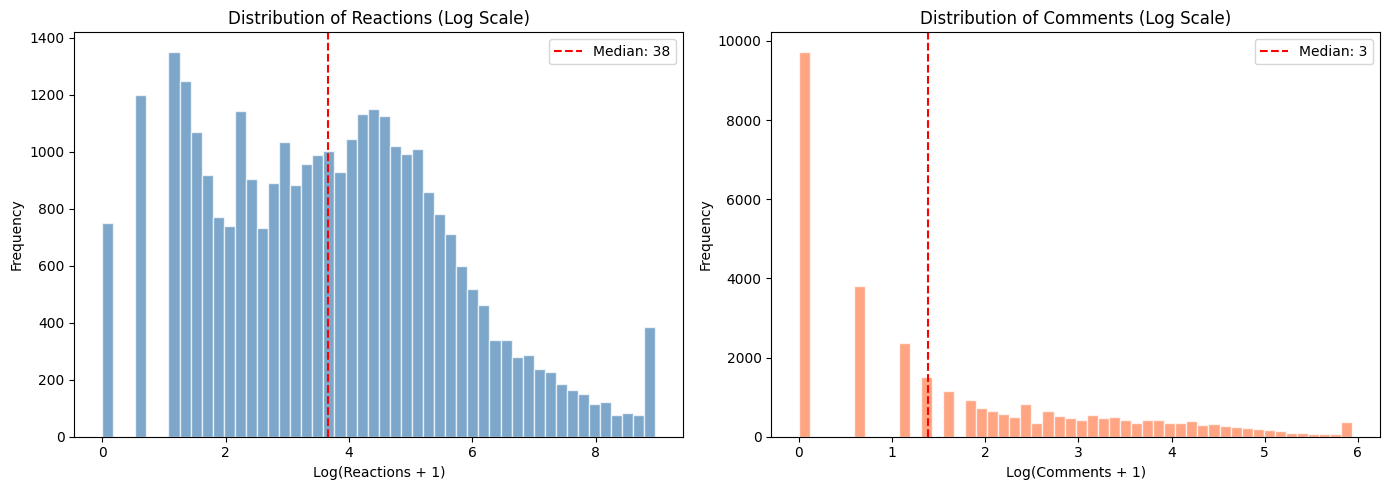

In [15]:
# Visualize distributions
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reactions distribution
if 'reactions' in df.columns:
    axes[0].hist(np.log1p(df['reactions']), bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    axes[0].set_xlabel('Log(Reactions + 1)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Reactions (Log Scale)')
    axes[0].axvline(np.log1p(df['reactions'].median()), color='red', linestyle='--', 
                    label=f'Median: {df["reactions"].median():.0f}')
    axes[0].legend()

# Comments distribution
if 'comments' in df.columns:
    axes[1].hist(np.log1p(df['comments']), bins=50, color='coral', edgecolor='white', alpha=0.7)
    axes[1].set_xlabel('Log(Comments + 1)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Comments (Log Scale)')
    axes[1].axvline(np.log1p(df['comments'].median()), color='red', linestyle='--', 
                    label=f'Median: {df["comments"].median():.0f}')
    axes[1].legend()

plt.tight_layout()
plt.show()

---
## 8. Save Cleaned Data

In [16]:
print("="*80)
print("SAVING CLEANED DATA")
print("="*80)

# Save cleaned dataframe
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILE)
df.to_csv(output_path, index=False)
print(f"✓ Saved cleaned data to: {output_path}")
print(f"  Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Save statistics
stats_summary = {
    'initial_rows': int(initial_rows),
    'final_rows': int(final_rows),
    'rows_removed': int(rows_removed),
    'removal_percentage': float(removal_pct),
    'duplicates_removed': int(duplicates_total),
    'missing_content': int(missing_summary.get('content', {}).get('count', 0)),
    'quality_issues_fixed': len(quality_issues),
    'outlier_stats': {k: {ik: float(iv) if isinstance(iv, (int, float, np.number)) else iv 
                          for ik, iv in v.items()} 
                     for k, v in outlier_stats.items()}
}

stats_path = os.path.join(OUTPUT_DIR, 'cleaning_stats.json')
with open(stats_path, 'w') as f:
    json.dump(stats_summary, f, indent=2)

print(f"✓ Saved statistics to: {stats_path}")

SAVING CLEANED DATA
✓ Saved cleaned data to: ../data\cleaned_data.csv
  Shape: 31,996 rows × 19 columns
✓ Saved statistics to: ../data\cleaning_stats.json


---
## ✅ Step 1.1 Complete

**Summary:**
- ✓ Data loaded successfully
- ✓ Duplicates removed
- ✓ Missing values handled
- ✓ Data types validated
- ✓ Outliers capped
- ✓ Quality checks passed
- ✓ Clean data saved

**Output Files:**
- `../data/cleaned_data.csv` - Clean dataset ready for preprocessing
- `../data/cleaning_stats.json` - Detailed statistics

**Next Step:** Step 1.2 - Text Preprocessing